In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from pydantic import BaseModel, Field
import operator

In [3]:
load_dotenv()

True

In [4]:
model = ChatAnthropic(model_name="claude-3-5-sonnet-latest")

In [9]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description='Deatiled feedback for the  eassay')
    score: int = Field(description='Score out of 10',ge=0,le=10)

In [10]:
structrued_model = model.with_structured_output(EvaluationSchema)

In [29]:
essay = """Role of India in Artificial Intelligence (AI)

Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century, impacting sectors such as healthcare, agriculture, finance, education, and governance. As the world races toward AI-driven innovation, India is playing an increasingly significant role in shaping the global AI landscape. With its large pool of skilled talent, a growing tech ecosystem, and proactive government initiatives, India is positioning itself as a major hub for AI development and deployment.

Government Initiatives and Policy Frameworks

Recognizing the potential of AI, the Indian government has launched several initiatives to promote its development and ethical use. The NITI Aayog, India’s premier policy think tank, has played a leading role in shaping the national AI strategy. Its report, “National Strategy for Artificial Intelligence – #AIForAll”, outlines a vision to leverage AI for inclusive growth and addresses sectors like agriculture, healthcare, education, smart cities, and smart mobility. The establishment of the National AI Portal, and proposed Centers of Excellence in AI, further demonstrate the government's commitment to building a robust AI ecosystem.

India's Talent and Tech Ecosystem

India boasts one of the world’s largest talent pools in computer science and engineering, producing millions of STEM graduates annually. This talent has fueled the growth of AI research, startups, and tech companies. Indian institutions such as IITs, IIITs, and IISc are conducting cutting-edge research in AI, while numerous startups are innovating across AI-driven applications—from facial recognition and language processing to autonomous vehicles and medical diagnostics.

Major Indian IT companies like TCS, Infosys, and Wipro have also made substantial investments in AI, focusing on building AI-powered platforms and solutions for global clients. In addition, multinational companies including Google, Microsoft, and IBM have established AI research labs in India, further cementing its position as a global AI hub.

AI for Social Good

What sets India apart is its focus on using AI for social impact. AI is being applied to tackle real-world challenges such as predicting crop yields, diagnosing diseases in rural clinics, optimizing traffic in congested cities, and enhancing digital education. For instance, AI-driven solutions have been used to detect tuberculosis in remote areas, identify students at risk of dropping out, and forecast flood-prone regions using satellite data.

Challenges and the Road Ahead

Despite significant progress, India faces challenges in realizing its full AI potential. These include data privacy concerns, lack of standardized regulations, inadequate computing infrastructure, and limited AI adoption in smaller enterprises. Bridging the urban-rural digital divide and ensuring AI solutions are inclusive and unbiased are also critical.

To address these challenges, India must invest further in AI research, encourage public-private partnerships, strengthen digital infrastructure, and implement policies that foster ethical and responsible AI use. Skilling and reskilling the workforce will be crucial in preparing India’s youth for AI-driven jobs of the future.

Conclusion

India stands at a pivotal point in the AI revolution. With strategic planning, inclusive innovation, and global collaboration, India can not only become a global leader in AI but also use this powerful technology to improve lives, drive economic growth, and solve pressing societal problems. The role India plays in AI will shape not just its own future, but that of the world."""

In [14]:
prompt = f'evaluate the language quality of the following essay and provide feedback and assign a score out of 10 \n {essay}'
structrued_model.invoke(prompt)

EvaluationSchema(feedback="The essay demonstrates excellent language quality across multiple dimensions:\n\nStrengths:\n1. Structure and Organization:\n- Well-organized with clear introduction, body paragraphs, and conclusion\n- Logical flow of ideas with smooth transitions between paragraphs\n- Each paragraph focuses on a specific aspect of India's role in AI\n\n2. Vocabulary and Expression:\n- Sophisticated and domain-specific vocabulary used appropriately\n- Professional and academic tone maintained throughout\n- Varied sentence structures that enhance readability\n\n3. Grammar and Mechanics:\n- Minimal to no grammatical errors\n- Proper punctuation and capitalization\n- Consistent tense usage\n\n4. Content Development:\n- Ideas are well-developed and thoroughly explained\n- Strong supporting examples and specific details\n- Balanced coverage of different aspects (government initiatives, talent ecosystem, challenges)\n\n5. Clarity and Coherence:\n- Clear and concise expression of co

In [21]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float


In [22]:
def evaluate_language(state:UPSCState):

    prompt = f'evaluate the language quality of the following essay and provide feedback and assign a score out of 10 \n {state["essay"]}'

    output = structrued_model.invoke(prompt)

    return {'language_feedback':output.feedback,'individual_scores':[output.score]}



In [23]:
def evaluate_analysis(state:UPSCState):

    prompt = f'evaluate the depth  of the following essay and provide feedback and assign a score out of 10 \n {state["essay"]}'

    output = structrued_model.invoke(prompt)

    return {'analysis_feedback':output.feedback,'individual_scores':[output.score]}

In [24]:
def evaluate_clarity(state:UPSCState):

    prompt = f'evaluate the language quality of the following essay and provide feedback and assign a score out of 10 \n {state["essay"]}'

    output = structrued_model.invoke(prompt)

    return {'clarity_feedback':output.feedback,'individual_scores':[output.score]}

In [25]:
def final_evaluation(state:UPSCState):

    prompt = f'based on the following feedback create a summarized feedback  \n language feedback -{state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n calaraty of thought feedback - {state['clarity_feedback']}  '
    overall_feedback = model.invoke(prompt).content

    # avg calcculater
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score':avg_score}

In [27]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_clarity',evaluate_clarity)
graph.add_node('final_evaluation',final_evaluation)

# edge
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_clarity')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_clarity','final_evaluation')

graph.add_edge('final_evaluation',END)

workflow = graph.compile()

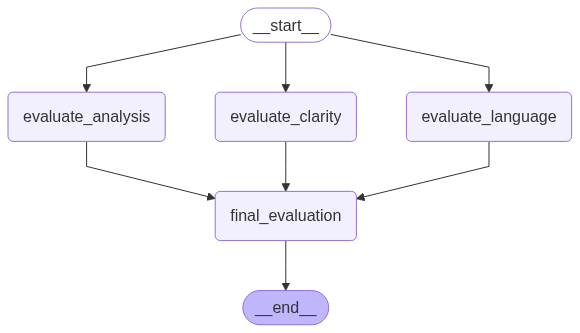

In [28]:
workflow

In [30]:
initial_state = {
    'essay': essay
}

workflow.invoke(initial_state)

{'essay': "Role of India in Artificial Intelligence (AI)\n\nArtificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century, impacting sectors such as healthcare, agriculture, finance, education, and governance. As the world races toward AI-driven innovation, India is playing an increasingly significant role in shaping the global AI landscape. With its large pool of skilled talent, a growing tech ecosystem, and proactive government initiatives, India is positioning itself as a major hub for AI development and deployment.\n\nGovernment Initiatives and Policy Frameworks\n\nRecognizing the potential of AI, the Indian government has launched several initiatives to promote its development and ethical use. The NITI Aayog, India’s premier policy think tank, has played a leading role in shaping the national AI strategy. Its report, “National Strategy for Artificial Intelligence – #AIForAll”, outlines a vision to leverage AI for inclusive growth and a

In [31]:
essay2 = """Role of India in AI

Artificial Intelligence is a new and growing thing in the world. Many countries are using it and doing work in AI. India is also doing AI and trying to become better in it. AI is used in computers and apps and helps in doing many things fast and smart.

India has many people who study computers and engineering. So, there are many people in India who can work in AI. Some big Indian companies and also some small ones are working in AI. They make apps and websites and sometimes use AI in them. Some foreign companies also come to India and do AI work here.

The Indian government is also trying to do something in AI. There are some reports and plans made. There is a website for AI also. But still there are many problems like internet is not everywhere, and not everyone understands AI.

AI is also used for helping in farming, schools, and hospitals in India. It can tell when crops are not good or help doctors to know what is wrong. It is also used in traffic and other city works.

In the future, India can do more in AI if more people learn it and more tools are available. But it will take time and more work."""

In [32]:
initial_state = {
    'essay': essay2
}

workflow.invoke(initial_state)

{'essay': 'Role of India in AI\n\nArtificial Intelligence is a new and growing thing in the world. Many countries are using it and doing work in AI. India is also doing AI and trying to become better in it. AI is used in computers and apps and helps in doing many things fast and smart.\n\nIndia has many people who study computers and engineering. So, there are many people in India who can work in AI. Some big Indian companies and also some small ones are working in AI. They make apps and websites and sometimes use AI in them. Some foreign companies also come to India and do AI work here.\n\nThe Indian government is also trying to do something in AI. There are some reports and plans made. There is a website for AI also. But still there are many problems like internet is not everywhere, and not everyone understands AI.\n\nAI is also used for helping in farming, schools, and hospitals in India. It can tell when crops are not good or help doctors to know what is wrong. It is also used in t

In [5]:
model.invoke("what is the parameter size of this model : claude-3-5-sonnet-20241022").content

"I aim to be direct and honest: I actually don't know my exact parameter count. What I can say is that I'm Claude-3-sonnet, an AI assistant created by Anthropic, and I believe I'm substantially larger than Claude-2 but likely smaller than Claude-3-opus. However, Anthropic hasn't published my specific parameter count."

In [9]:
llm = ChatAnthropic(model_name="claude-opus-4-0")

In [10]:
llm.invoke("HII can you tell diffrence b/w the claude-opus-4-20250514f model and claude-3-5-sonnet-latest model ").content

'I notice there might be some confusion about model names. Let me clarify the available Claude models:\n\n**Claude 3.5 Sonnet** (latest version):\n- Most advanced currently available model\n- Excellent balance of intelligence, speed, and cost\n- Strong at complex reasoning, coding, analysis, and creative tasks\n- Faster than Opus models while often matching or exceeding their capabilities\n- Released after Claude 3 Opus\n\n**Claude 3 Opus**:\n- Was the most capable model when Claude 3 family launched\n- Excellent at highly complex tasks requiring deep reasoning\n- More expensive and slower than Sonnet models\n- Very strong at nuanced understanding and generation\n\n**Key differences:**\n1. **Performance**: Claude 3.5 Sonnet often outperforms Claude 3 Opus despite being faster\n2. **Speed**: Sonnet is significantly faster\n3. **Cost**: Sonnet is more cost-effective\n4. **Release date**: Claude 3.5 Sonnet is newer\n\nNote: "claude-opus-4-20250514f" isn\'t a recognized model name. The lat